In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [ ]:
fake = pd.read_csv("/content/Fake-210604-161841.csv", engine= None )
true = pd.read_csv("/content/True-210604-161650.csv", engine= None)

In [ ]:
fake.shape

(23481, 4)

In [ ]:
true.shape

(21417, 4)

In [ ]:
fake['target'] = 'fake'
true['target'] = 'true'

In [ ]:
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [ ]:
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [ ]:
data.head()

,text,subject,date,target
0,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"March 8, 2017",true
1,Member Statements Senator Chuck Grassley R (IA...,politics,"Jan 10, 2017",fake
2,PARIS (Reuters) - France on Friday firmly back...,worldnews,"December 15, 2017",true
3,"According to insider, and author Edward Klein,...",left-news,"Mar 9, 2016",fake
4,"BEIJING (Reuters) - A top Chinese coal miner, ...",worldnews,"November 9, 2017",true


In [ ]:
# Removing the title (we will only use the text)

In [ ]:
data.head()

,text,subject,date,target
0,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"March 8, 2017",true
1,Member Statements Senator Chuck Grassley R (IA...,politics,"Jan 10, 2017",fake
2,PARIS (Reuters) - France on Friday firmly back...,worldnews,"December 15, 2017",true
3,"According to insider, and author Edward Klein,...",left-news,"Mar 9, 2016",fake
4,"BEIJING (Reuters) - A top Chinese coal miner, ...",worldnews,"November 9, 2017",true


In [ ]:
# Convert to lowercase
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,date,target
0,washington (reuters) - president donald trump ...,politicsNews,"March 8, 2017",true
1,member statements senator chuck grassley r (ia...,politics,"Jan 10, 2017",fake
2,paris (reuters) - france on friday firmly back...,worldnews,"December 15, 2017",true
3,"according to insider, and author edward klein,...",left-news,"Mar 9, 2016",fake
4,"beijing (reuters) - a top chinese coal miner, ...",worldnews,"November 9, 2017",true


In [ ]:
# Remove punctuation
import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [ ]:
data.head()

,text,subject,date,target
0,washington reuters president donald trump is ...,politicsNews,"March 8, 2017",true
1,member statements senator chuck grassley r ia ...,politics,"Jan 10, 2017",fake
2,paris reuters france on friday firmly backed ...,worldnews,"December 15, 2017",true
3,according to insider and author edward klein h...,left-news,"Mar 9, 2016",fake
4,beijing reuters a top chinese coal miner yank...,worldnews,"November 9, 2017",true


In [ ]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data.head()

,text,subject,date,target
0,washington reuters president donald trump “ext...,politicsNews,"March 8, 2017",true
1,member statements senator chuck grassley r ia ...,politics,"Jan 10, 2017",fake
2,paris reuters france friday firmly backed unle...,worldnews,"December 15, 2017",true
3,according insider author edward klein hillary ...,left-news,"Mar 9, 2016",fake
4,beijing reuters top chinese coal miner yankuan...,worldnews,"November 9, 2017",true


subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


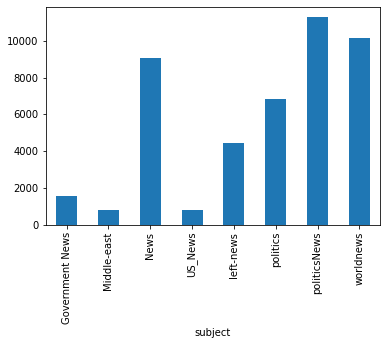

In [ ]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


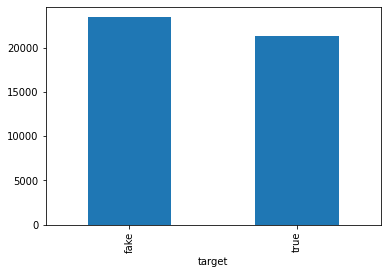

In [ ]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

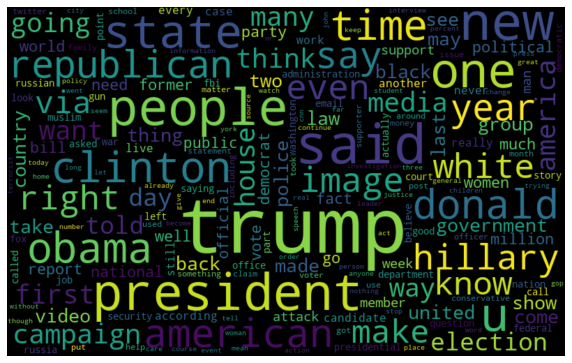

In [ ]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

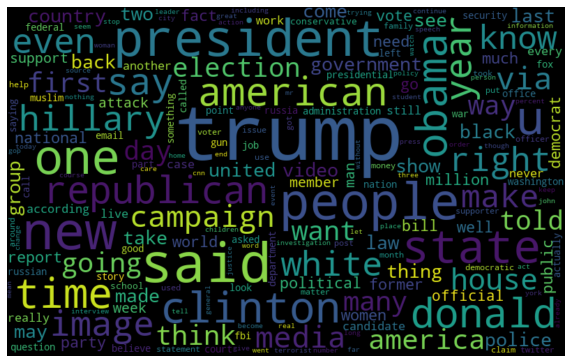

In [ ]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

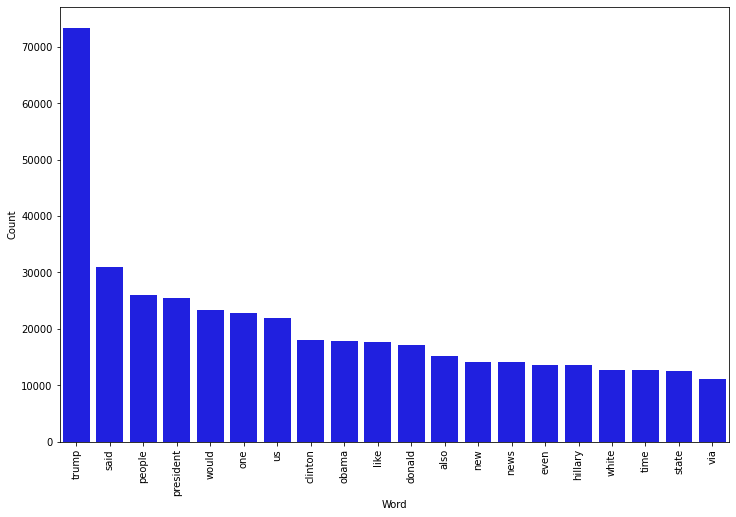

In [ ]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

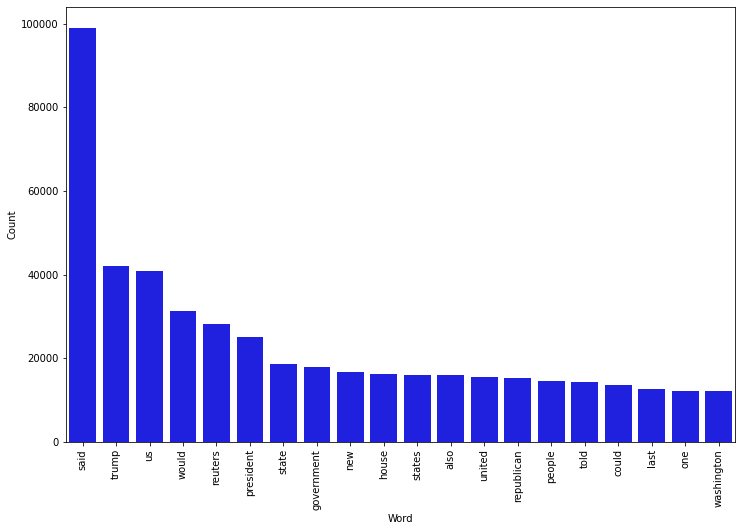

In [ ]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

In [ ]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [ ]:
#Logistic regression

In [ ]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.03%


Confusion matrix, without normalization


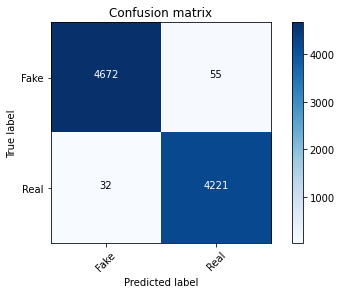

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [ ]:
#Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.76%


In [ ]:
#Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.12%


Confusion matrix, without normalization


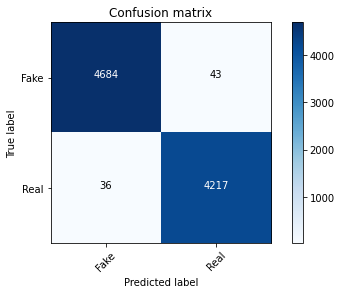

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])